# 3. Topic Modeling
In this notebook we will perform the initial topic modeling of the COVID and Agriculture datasets for the publications track of Hercules project. This phase will consist on the preprocessing of each dataset and the training of several topic models to infer the topics of each corpus.

## Setup

In [1]:
%run __init__.py

In [2]:
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/home/alejandro/.envs/edma/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
RANDOM_SEED = 42

NOTEBOOK_RESULTS_DIR = os.path.join(RESULTS_DIR, '3_topic_modeling')

## Common functions

Before we start working with our first dataset, we are going a common set of functionality that will be used in both datasets. First of all, we will define a function to print a word cloud based on the given text:

In [4]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt


def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


We also will implement a custom class to perform the preprocessing of texts before they are used by the topic extraction models. This preprocessing will consist of the tokenization of each text, stop word removal and lemmatization. The [Spacy](https://spacy.io) library will be used for this task. Our TextPreprocessor class will allow the use of a custom Spacy model for each different dataset, as we will see later:

In [5]:
import multiprocessing as mp
import string

from joblib import Parallel, delayed
from tqdm.notebook import tqdm

import numpy as np
import spacy

from sklearn.base import TransformerMixin, BaseEstimator
from spacy.util import minibatch


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, spacy_model, additional_stopwords=None, disable=None):
        self.disable = disable if disable is not None else []
        self.custom_stop_words = additional_stopwords if additional_stopwords is not None else []
        self.nlp = spacy_model.load(disable=self.disable)

    def fit(self, X, y=None):
        return self

    def transform(self, X, *args, **kwargs):
        return self._preprocess_docs(X)
    
    def _preprocess_docs(self, X):
        preproc_pipe = []
        for doc in tqdm(self.nlp.pipe(X)):
            preproc_pipe.append(self._get_doc_tokens(doc))
        return preproc_pipe
    
    def _get_doc_tokens(self, doc):
        return [t.lemma_ for t in doc if len(t.text) > 2 and
                not self._is_stop_word(t) and t.text not in string.punctuation
                and t.is_alpha and not t.is_digit]

    def _is_stop_word(self, token):
        return token.is_stop or token.text.lower() in self.custom_stop_words
    

The following function will be used to show the top terms of each topic extracted by a given model:

In [6]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


This next set of functions will be use to evaluate our topic extraction models after they have been trained. In the first cell we are making use of the [tmtoolkit](https://tmtoolkit.readthedocs.io/en/latest/) library to obtain the topic coherence of a given model. Specifically, we will be using the _u\_mass_ measure.

The second cell consists of a list of functions to try out several combinations of topics for each given model, and return the model with the best topic coherence amongst them.

In [7]:
import numpy as np

from tmtoolkit.topicmod.evaluate import metric_coherence_gensim


def base_scoring_function(vectorizer, texts, model, X, top_n=20):
    return metric_coherence_gensim(measure='u_mass', dtm=X, 
                                   topic_word_distrib=model.components_,
                                   vocab=np.array([x for x in vectorizer.vocabulary_.keys()]), 
                                   texts=texts, return_mean=True)

In [8]:
MIN_TOPICS = 7
MAX_TOPICS = 30

def try_topics(model_cls, X, scoring_func, **kwargs):
    res = {}
    for num_topics in range(MIN_TOPICS, MAX_TOPICS):
        model = model_cls(n_components=num_topics, random_state=RANDOM_SEED, **kwargs)
        model.fit(X)
        score = scoring_func(model, X)
        res[model] = score
    return res

def print_results_info(model_results):
    best_model = get_best_model(model_results)
    print(f"Best model parameters: {best_model.get_params()}")
    print(f"Topic coherence: {model_results[best_model]}")

def get_best_model(model_results):
    return max(model_results, key=model_results.get)


Finally, we will define a final function to serialize our pipelines so we can load them later on in the following notebooks to obtain the topics of a given piece of text:

In [9]:
import dill as pickle

def save_object(obj, output_path):
    with open(output_path, 'wb') as file:
        pickle.dump(obj, file)


Now that we have defined our common set of functions, we can start working on each dataset.

## COVID-19

### Loading the dataframe
Since we have already saved a pandas dataframe in the previous notebook, we will begin by loading it:

In [5]:
CORD_DATASET_DIR = os.path.join(DATA_DIR, 'cord19')
CORD19_FILE_PATH = os.path.join(CORD_DATASET_DIR, 'cord19_dataframe.pkl')

cord19_df = pd.read_pickle(CORD19_FILE_PATH)
cord19_df.head()

,id,title,abstract,full_body,authors,references,subjects,text_cleaned,num_chars_text
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,Absence of surface expression of feline infect...,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,E Cornelissen|H L Dewerchin|E Van Hamme|H J N...,Using direct immunofluorescence to detect coro...,,Feline infectious peritonitis (FIP) is a fatal...,13275
1,00016663c74157a66b4d509d5c4edffd5391bbe0,,,Viruses are increasingly recognised as pathoge...,,Principles of Virology in Fields Virology|Inac...,,Viruses are increasingly recognised as pathoge...,64408
2,0003793cf9e709bc2b9d0c8111186f78fb73fc04,Title: Rethinking high-risk groups in COVID-19,,How do we protect our 'high-risk' patient popu...,Anastasia Vishnevetsky|Michael Levy,COVID-19)|Prevalence of comorbidities in the n...,,How do we protect our 'high-risk' patient popu...,6243
3,00039b94e6cb7609ecbddee1755314bcfeb77faa,Plasma inflammatory cytokines and chemokines i...,Severe acute respiratory syndrome (SARS) is a ...,Severe acute respiratory syndrome (SARS) is a ...,W K Lam|C K Wong|C W K Lam|A K L Wu|W K Ip|N L...,A major outbreak of severe acute respiratory s...,,Severe acute respiratory syndrome (SARS) is a ...,18655
4,0003ddc51c4291d742855e9ac56076a3bea33ad7,Journal Pre-proofs The Fire This Time: The Str...,,It is said that crisis reveals character. The ...,Olusola Ajilore|April D Thames,Ethnic Disparities in Hospitalisation for COVI...,,It is said that crisis reveals character. The ...,6829


As we have already seen, some of the articles from this dataset can be really long (aroung $3*10^6$ characters), we will begin by reducing the size of each article to a given threshold. After that, we will remove the cord19 dataframe to save some memory since we won't be using it anymore: 

In [6]:
MAX_ARTICLE_LENGTH = 100000

covid_articles = [article[:MAX_ARTICLE_LENGTH] for article in cord19_df['text_cleaned'].values]
del cord19_df

len(covid_articles)

129982

### Preprocessing text

Now that we have every article to be processed, we can start preprocessing our text. To do that, we will create an instance of the _TextPreprocessor_ class defined above, and pass it the list of texts to be processed:
> This task may take a long time depending on the resources of the machine were it is being run.

In [7]:
import en_core_web_md

custom_stop_words = {"et","al", "introduction", "fig", "figure", "figures" "figs", "abstract"}

covid_preprocessor = TextPreprocessor(en_core_web_md, custom_stop_words, n_jobs=0)
covid_preprocessed = covid_preprocessor.fit_transform(covid_articles)

Since we won't be using the original texts anymore, we can also remove them from memory:

In [8]:
del covid_articles

Before moving to the next steps, we will make a word cloud to examine if there are some interesting terms or singularities about this dataset. It will also help us with making an initial approximation to the dataset and the topics that we may extract:

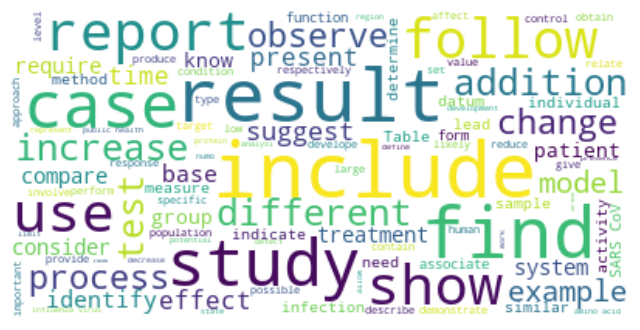

In [15]:
plot_word_cloud(' '.join([' '.join(token) for token in covid_preprocessed[::50]]))

### LDA
We will extract topics for the COVID-19 dataset using the Latent Dirichlet Allocation (LDA) model. In order to use this model, we first need to obtain a term frequency representation of the tokens obtained in the previous section:

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc

covid_tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
covid_dtm_tf = covid_tf_vectorizer.fit_transform(covid_preprocessed)

Now that we have the vector representation of each text, we can train the LDA model:

In [ ]:
from functools import partial

from sklearn.decomposition import LatentDirichletAllocation

covid_lda = LatentDirichletAllocation(n_components=50, random_state=RANDOM_SEED)
covid_lda.fit(covid_dtm_tf)

In the following cell we will print the term distribution of each topic that has been modelled. For each topic, we will show the top 10 terms:

In [21]:
print_top_words(covid_lda, covid_tf_vectorizer.get_feature_names(), 10)

Topic #0: preprint license medRxiv author copyright grant funder display holder perpetuity
Topic #1: study health participant social group student information experience people high
Topic #2: antibody serum mouse group protein anti IgG PBS day incubate
Topic #3: case datum numb model estimate time rate population report country
Topic #4: cell protein virus infection viral show infect bind membrane result
Topic #5: study patient influenza group pneumonia child infection age year include
Topic #6: patient disease study increase risk level high severe associate report
Topic #7: disease outbreak pandemic epidemic public contact spread health case risk
Topic #8: patient lung pulmonary respiratory day pneumonia disease severe case acute
Topic #9: care use patient system hospital hand include facility staff health
Topic #10: infant woman pregnancy birth rabbit rat pregnant maternal mother study
Topic #11: cat pig PEDV infection sample group study infect piglet positive
Topic #12: health publi

In [ ]:
pyLDAvis.sklearn.prepare(covid_lda, covid_dtm_tf, covid_tf_vectorizer, mds='tsne')

Finally, we are going to serialize our final pipeline so that it can be used in other notebooks to extract the topics of a given text. This pipeline consists of:
* 'preprocessing': Text preprocessing step. A string is given to this transformer, and a list of lemmatized tokens without stop words is returned.
* 'vectorizer': This step will receive the tokens from the text preprocessing and will return a vector form of each document with its term frequency.
* 'model': Finally, the vector input will be given to the LDA model, which will return the probability of the text belonging to each topic.

In [24]:
import pickle

from sklearn.pipeline import Pipeline

covid_lda_pipeline = Pipeline([('preprocessing', covid_preprocessor),
                               ('vectorizer', covid_tf_vectorizer),
                               ('model', covid_lda)])

covid_pipe_filename = "covid_lda_model.pkl"
save_object(covid_lda_pipeline, os.path.join(NOTEBOOK_RESULTS_DIR, covid_pipe_filename))

TODO: train model with several different n\_components parameters and analyze results.

In [ ]:
from functools import partial

from sklearn.decomposition import LatentDirichletAllocation


covid_lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=covid_tf_vectorizer,
                                            texts=covid_preprocessed, model=clf, X=X)


covid_lda_results = try_topics(LatentDirichletAllocation, covid_dtm_tf, covid_lda_scoring_func)
covid_lda_results

In [ ]:
print_results_info(lda_results)
best_lda_model = get_best_model(lda_results)

## Agriculture

### Loading the dataframe

In [10]:
AGRICULTURE_DATASET_DIR = os.path.join(DATA_DIR, 'agriculture')
PMC_FILE_PATH = os.path.join(AGRICULTURE_DATASET_DIR, 'pmc_dataframe.pkl')

pmc_df = pd.read_pickle(PMC_FILE_PATH)

### Preprocessing text

In [11]:
publications = pmc_df['text_cleaned'].values

In [12]:
import en_core_web_sm
import en_core_web_md

import en_core_sci_sm

custom_stop_words = {"et","al", "introduction", "fig", "figure", "figures" "figs", "abstract"}

agriculture_preprocessor = TextPreprocessor(en_core_web_md, custom_stop_words)
preprocessed_texts = agriculture_preprocessor.fit_transform(publications)

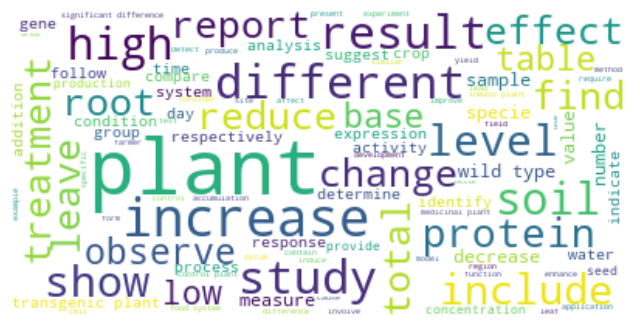

In [13]:
complete_text = ' '.join([' '.join(token) for token in preprocessed_texts])

plot_word_cloud(complete_text)

### LDA

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc


tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
dtm_tf = tf_vectorizer.fit_transform(preprocessed_texts)

In [15]:
from functools import partial

from sklearn.decomposition import LatentDirichletAllocation


lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tf_vectorizer,
                                        texts=preprocessed_texts, model=clf, X=X)


lda_results = try_topics(LatentDirichletAllocation, dtm_tf, lda_scoring_func)
lda_results

/home/alejandro/.envs/edma/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


{LatentDirichletAllocation(n_components=7, random_state=42): -1.0837954732908297,
 LatentDirichletAllocation(n_components=8, random_state=42): -1.0471647332538256,
 LatentDirichletAllocation(n_components=9, random_state=42): -0.8194707195743496,
 LatentDirichletAllocation(random_state=42): -1.3031982586603874,
 LatentDirichletAllocation(n_components=11, random_state=42): -1.010456411529431,
 LatentDirichletAllocation(n_components=12, random_state=42): -1.1079660335416823,
 LatentDirichletAllocation(n_components=13, random_state=42): -1.0961940683781926,
 LatentDirichletAllocation(n_components=14, random_state=42): -1.5283454628386743,
 LatentDirichletAllocation(n_components=15, random_state=42): -1.443568286105536,
 LatentDirichletAllocation(n_components=16, random_state=42): -1.2607094700525856,
 LatentDirichletAllocation(n_components=17, random_state=42): -1.2413675494972747,
 LatentDirichletAllocation(n_components=18, random_state=42): -1.537346283526662,
 LatentDirichletAllocation(

In [16]:
print_results_info(lda_results)
best_lda_model = get_best_model(lda_results)

Best model parameters: {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 9, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
Topic coherence: -0.8194707195743496


Visualization. Do this with the best model obtained before.

In [17]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, 10)

Topic #0: food system production habitat grassland agricultural level value change land
Topic #1: plant expression gene root stress level adaptation shoot show yield
Topic #2: base system crop agricultural sensor node farming breeding agriculture datum
Topic #3: soil rice crop high increase yield study practice water residue
Topic #4: plant stress gene increase level root treatment expression protein high
Topic #5: crop grain study rodent high line genotype gene show stage
Topic #6: plant transgenic growth light line protein level high gene Arabidopsis
Topic #7: plant medicinal take decoction Herb informant orally Wild study area
Topic #8: plant root gene non high control virus expression increase show



In [18]:
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tf, tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      111.092506 -133.722946       1        1  26.937082
8       34.946613  107.064590       2        1  23.325540
3      -28.088213 -159.949036       3        1  14.272549
6      147.698074   21.369604       4        1   8.081171
2      -97.501183  126.981384       5        1   7.207977
1       30.312096  -32.794945       6        1   6.569099
7     -155.443665 -118.494690       7        1   6.136062
0     -204.248108   22.596130       8        1   3.908973
5      -79.404678   -6.864717       9        1   3.561547, topic_info=           Term          Freq         Total Category  logprob  loglift
23481     plant  13870.000000  13870.000000  Default  30.0000  30.0000
25886      soil   2457.000000   2457.000000  Default  29.0000  29.0000
25016      rice   1960.000000   1960.000000  Default  28.0000  28.0000
26713    system   1621.000000   1621.000000  Default  27.0000  27.0000
18223      food    838.000000    838.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
13378  analysis     66.034274   1343.827403   Topic9  -5.6001   0.3219
27933     value     64.213312   1222.296054   Topic9  -5.6280   0.3887
23481     plant     71.283510  13870.481621   Topic9  -5.5236  -1.9359
24079   protein     64.390483   1644.332980   Topic9  -5.6253   0.0949
24897    result     64.362636   1798.818023   Topic9  -5.6257   0.0046

[685 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
12         1  0.362619    ABA
12         2  0.052882    ABA
12         4  0.521265    ABA
12         6  0.060437    ABA
69         1  0.992212   ALDH
...      ...       ...    ...
28424      8  0.001869  yield
28424      9  0.071020  yield
28457      1  0.960944   zinc
28457      2  0.032464   zinc
28457      3  0.006493   zinc

[1940 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 4, 7, 3, 2, 8, 1, 6])

In [20]:
from sklearn.pipeline import Pipeline

lda_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lda_model)])

lda_agriculture_pipe_filename = "agriculture_lda_model.pkl"
save_object(lda_pipeline, os.path.join(NOTEBOOK_RESULTS_DIR, lda_agriculture_pipe_filename))

In [21]:
dtm_tf_filename = "agriculture_dtm_tf.pkl"

save_object(dtm_tf, os.path.join(NOTEBOOK_RESULTS_DIR, dtm_tf_filename))

#### LDA with bigrams

In [28]:
bigram_tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 2))
bigram_dtm_tf = bigram_tf_vectorizer.fit_transform(preprocessed_texts)


bigram_lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=bigram_tf_vectorizer,
                                                               texts=preprocessed_texts, model=clf, X=X)


bigram_lda_results = try_topics(LatentDirichletAllocation, bigram_dtm_tf, bigram_lda_scoring_func)
bigram_lda_results

{LatentDirichletAllocation(n_components=7, random_state=42): -1.2017155538133848,
 LatentDirichletAllocation(n_components=8, random_state=42): -1.5446284596199416,
 LatentDirichletAllocation(n_components=9, random_state=42): -1.3076811616312258,
 LatentDirichletAllocation(random_state=42): -2.101928885340357,
 LatentDirichletAllocation(n_components=11, random_state=42): -2.1838057091196905,
 LatentDirichletAllocation(n_components=12, random_state=42): -1.4993139483543134,
 LatentDirichletAllocation(n_components=13, random_state=42): -1.2578391704462746,
 LatentDirichletAllocation(n_components=14, random_state=42): -1.3800613661406504,
 LatentDirichletAllocation(n_components=15, random_state=42): -1.5280639543890713,
 LatentDirichletAllocation(n_components=16, random_state=42): -2.5504900912110857,
 LatentDirichletAllocation(n_components=17, random_state=42): -2.498077689908472,
 LatentDirichletAllocation(n_components=18, random_state=42): -2.6921871930676833,
 LatentDirichletAllocation

In [29]:
best_bigram_lda_model = get_best_model(bigram_lda_results)

pyLDAvis.sklearn.prepare(best_bigram_lda_model, bigram_dtm_tf, bigram_tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4     -29.594002  60.112713       1        1  33.078419
0     -45.996586  11.891685       2        1  21.419932
3      20.368856  70.019325       3        1  16.014011
5      53.928768  31.704309       4        1  12.881971
2     -12.437127 -26.423267       5        1   7.261467
6       3.965971  21.797720       6        1   4.949410
1      37.524284 -16.517805       7        1   4.394789, topic_info=              Term          Freq         Total Category  logprob  loglift
220837       plant  11752.000000  11752.000000  Default  30.0000  30.0000
280210      stress   2264.000000   2264.000000  Default  29.0000  29.0000
146796        gene   2056.000000   2056.000000  Default  28.0000  28.0000
271561        soil   2069.000000   2069.000000  Default  27.0000  27.0000
142244        food    646.000000    646.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
308736       virus     44.918931    472.818996   Topic7  -6.8886   0.7709
215006     pathway     42.437279    358.853634   Topic7  -6.9455   0.9899
298044  transgenic     42.563324    874.697524   Topic7  -6.9425   0.1019
181086       level     44.210851   1744.906403   Topic7  -6.9045  -0.5507
266246        show     40.815088   1520.842846   Topic7  -6.9844  -0.4932

[560 rows x 6 columns], token_table=        Topic      Freq   Term
term                          
32          1  0.229330    ABA
32          3  0.426660    ABA
32          4  0.010667    ABA
32          7  0.330662    ABA
370         3  0.992529   ALDH
...       ...       ...    ...
314149      7  0.002277  yield
314771      1  0.971802   zinc
314771      2  0.014724   zinc
314771      3  0.007362   zinc
314771      4  0.007362   zinc

[1375 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 6, 3, 7, 2])

In [30]:
bigram_lda_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                                ('vectorizer', bigram_tf_vectorizer),
                                ('model', best_bigram_lda_model)])

lda_bigram_agriculture_pipe_filename = "agriculture_bigram_lda_model.pkl"
save_object(lda_pipeline, os.path.join(NOTEBOOK_RESULTS_DIR, lda_bigram_agriculture_pipe_filename))

### Latent Semantic Analysis (LSA)

In [31]:
from sklearn.decomposition import TruncatedSVD

lsa_scoring_func = lda_scoring_func

lsa_results = try_topics(TruncatedSVD, dtm_tf, lsa_scoring_func)
lsa_results

{TruncatedSVD(n_components=7, random_state=42): -1.2314902894753053,
 TruncatedSVD(n_components=8, random_state=42): -1.6499192126663633,
 TruncatedSVD(n_components=9, random_state=42): -1.6940250130674832,
 TruncatedSVD(n_components=10, random_state=42): -1.7154595809715478,
 TruncatedSVD(n_components=11, random_state=42): -1.7578995591676312,
 TruncatedSVD(n_components=12, random_state=42): -1.8144756438710077,
 TruncatedSVD(n_components=13, random_state=42): -1.766097981452892,
 TruncatedSVD(n_components=14, random_state=42): -1.7454279451984536,
 TruncatedSVD(n_components=15, random_state=42): -1.8121132759461258,
 TruncatedSVD(n_components=16, random_state=42): -1.8880011325921193,
 TruncatedSVD(n_components=17, random_state=42): -1.935695462259353,
 TruncatedSVD(n_components=18, random_state=42): -2.20447991643126,
 TruncatedSVD(n_components=19, random_state=42): -2.077693539861157,
 TruncatedSVD(n_components=20, random_state=42): -2.114721283193569,
 TruncatedSVD(n_components=21

In [32]:
print_results_info(lsa_results)
best_lsa_model = get_best_model(lsa_results)

Best model parameters: {'algorithm': 'randomized', 'n_components': 7, 'n_iter': 5, 'random_state': 42, 'tol': 0.0}
Topic coherence: -1.2314902894753053


In [33]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lsa_model, tf_feature_names, 10)

Topic #0: plant stress gene high increase expression level root protein show
Topic #1: system soil food crop rice increase high base level agricultural
Topic #2: decoction orally take Wild medicinal Herb system grinding food area
Topic #3: food system plant virus production value infect regime chain agricultural
Topic #4: stress food system take heat orally decoction Wild gene Herb
Topic #5: root gene expression soil transgenic protein fungus mutant shoot fungal
Topic #6: root MED NUT treatment report application Karst system food informant



In [34]:
from sklearn.decomposition import TruncatedSVD

lsa_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lsa_model)])

lsa_agriculture_pipe_filename = "agriculture_lsa_model.pkl"
save_object(lsa_pipeline, os.path.join(NOTEBOOK_RESULTS_DIR, lsa_agriculture_pipe_filename))

### NMF

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
dtm_tfidf = tfidf_vectorizer.fit_transform(preprocessed_texts)

In [36]:
from sklearn.decomposition import NMF

nmf_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tfidf_vectorizer,
                                                        texts=preprocessed_texts, model=clf, X=X)

nmf_results = try_topics(NMF, dtm_tfidf, nmf_scoring_func, max_iter=300)
nmf_results

/home/alejandro/.envs/edma/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/alejandro/.envs/edma/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


{NMF(max_iter=300, n_components=7, random_state=42): -0.7983189878636967,
 NMF(max_iter=300, n_components=8, random_state=42): -1.1112626905819627,
 NMF(max_iter=300, n_components=9, random_state=42): -1.1096411686916055,
 NMF(max_iter=300, n_components=10, random_state=42): -1.0569192294085819,
 NMF(max_iter=300, n_components=11, random_state=42): -1.0998954963188956,
 NMF(max_iter=300, n_components=12, random_state=42): -1.1153609969626361,
 NMF(max_iter=300, n_components=13, random_state=42): -1.1079329669737523,
 NMF(max_iter=300, n_components=14, random_state=42): -1.0249519202221398,
 NMF(max_iter=300, n_components=15, random_state=42): -0.9426696840276994,
 NMF(max_iter=300, n_components=16, random_state=42): -0.9389659645277915,
 NMF(max_iter=300, n_components=17, random_state=42): -0.9278639743569896,
 NMF(max_iter=300, n_components=18, random_state=42): -0.956876693130418,
 NMF(max_iter=300, n_components=19, random_state=42): -0.96601332559656,
 NMF(max_iter=300, n_components

In [37]:
print_results_info(nmf_results)
best_nmf_model = get_best_model(nmf_results)

Best model parameters: {'alpha': 0.0, 'beta_loss': 'frobenius', 'init': None, 'l1_ratio': 0.0, 'max_iter': 300, 'n_components': 7, 'random_state': 42, 'shuffle': False, 'solver': 'cd', 'tol': 0.0001, 'verbose': 0}
Topic coherence: -0.7983189878636967


In [38]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(best_nmf_model, tfidf_feature_names, 10)

Topic #0: plant virus infect non population tomato sample value volatile specie
Topic #1: soil rice crop increase high root study yield residue different
Topic #2: plant take decoction orally Wild Herb medicinal grinding treat area
Topic #3: system food production agricultural base value level regime chain type
Topic #4: stress plant heat increase condition high tolerance level growth salt
Topic #5: plant gene expression protein root transgenic show transcript level control
Topic #6: plant MED NUT treatment report application informant Karst use oral



In [39]:
nmf_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tfidf_vectorizer),
                         ('model', best_nmf_model)])

nmf_agriculture_pipe_filename = "agriculture_nmf_model.pkl"
save_object(nmf_pipeline, os.path.join(NOTEBOOK_RESULTS_DIR, nmf_agriculture_pipe_filename))

### Corex

In [40]:
import scipy.sparse as ss

from corextopic import corextopic as ct
from corextopic import vis_topic as vt


corex_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, binary=True)
binary_tf = corex_vectorizer.fit_transform(preprocessed_texts)
sparse_binary_tf = ss.csr_matrix(binary_tf)

sparse_binary_tf.shape # n_docs x m_words

(126, 28548)

In [41]:
corex_words = corex_vectorizer.get_feature_names()

corex_model = ct.Corex(n_hidden=40, words=corex_words, max_iter=200, verbose=False, seed=RANDOM_SEED)
corex_model.fit(sparse_binary_tf, words=corex_words)

In [42]:
def print_corex_topics(model):
    corex_topics = model.get_topics()
    for n, topic in enumerate(corex_topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))

print_corex_topics(corex_model)

0: capillary,temperate,wine,Roth,acute,nearby,western,vouch,poison,popularity
1: cassette,novel,Solanaceae,enlarge,tertiary,mutually,regulated,aspect,drying,event
2: synthesis,expression,RNA,gene,cDNA,transcript,acid,transcription,induce,induction
3: school,foster,stakeholder,opinion,think,Kim,prone,preference,formal,Change
4: PCR,manufacturer,primer,pcr,isolate,kit,gel,rna,instruction,extraction
5: metal,weed,mutation,tube,organ,exhibit,price,pollen,coli,tip
6: refer,space,attention,heterogeneity,horizontal,opportunity,μmol,learning,diet,permission
7: March,custom,hydroxyl,husbandry,February,Northern,Euphorbiaceae,source,pharmacological,belowground
8: supernatant,wash,incubate,homogenize,centrifuge,methanol,concentration,suspension,freeze,mixture
9: scanning,randomized,sunflower,drug,oil,obviously,sensitive,Biotech,pollinator,gently
10: penetrate,sativum,wood,north,pixel,intake,away,worldwide,consistency,product
11: view,deal,significant,fire,coexist,university,pay,concept,partly,cent

Visualizing best number of topics

In [43]:
import matplotlib.pyplot as plt

%matplotlib inline

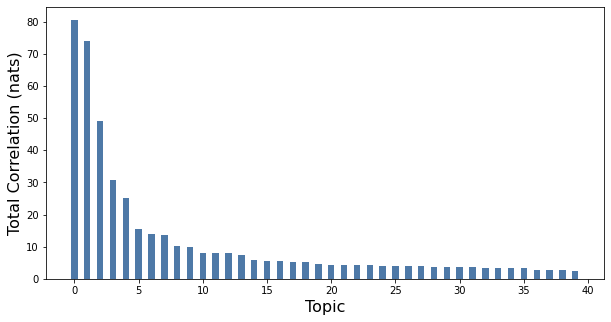

In [44]:
plt.figure(figsize=(10,5))
plt.bar(range(corex_model.tcs.shape[0]), corex_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

In [45]:
corex_model.tcs

array([80.56496667, 74.08301014, 49.26622724, 30.73248189, 25.11310672,
       15.58104339, 14.0911575 , 13.55701838, 10.28949711,  9.83679354,
        8.17300574,  8.10510045,  7.87506396,  7.5566357 ,  5.87926185,
        5.53440876,  5.47748778,  5.38008253,  5.29580952,  4.64905607,
        4.43680423,  4.33694614,  4.3289126 ,  4.31021268,  4.01998372,
        3.99584318,  3.95414694,  3.95378957,  3.79183715,  3.69649734,
        3.64670324,  3.55948848,  3.45516046,  3.31902153,  3.27896755,
        3.20604554,  2.87687214,  2.70761452,  2.68303455,  2.38211892])

Building the final model

In [46]:
corex_model = ct.Corex(n_hidden=12, words=corex_words, max_iter=200, verbose=False, seed=RANDOM_SEED)
corex_model.fit(sparse_binary_tf, words=corex_words)

In [47]:
print_corex_topics(corex_model)

0: accumulation,transcript,amino,accumulate,fold,dna,forest,dark,induction,Aldrich
1: photosynthetic,induce,biosynthesis,ROS,tissue,synthesis,acid,cell,chlorophyll,regulation
2: manipulation,richness,transfer,modify,succeed,hoc,thin,directly,magnesium,sunlight
3: supernatant,wind,incubator,sodium,investment,distil,assay,homogenize,technology,management
4: balance,uniformity,continent,rabbit,carbon,frequency,histidine,holder,malate,stick
5: annual,informant,rosette,child,west,desert,pain,independent,region,Invitrogen
6: official,river,biosynthesize,schematic,Taq,NanoDrop,control,drainage,system,mass
7: coastal,Heat,evening,extrapolate,Service,States,sterilized,injection,role,Winter
8: cultivar,east,circumstance,actually,steel,napus,lock,globally,isotope,compute
9: reservoir,flat,false,design,fungus,exploration,mineralize,screw,clock,fan
10: season,probably,contact,respective,summary,wetland,Quantification,flood,fragment,cassette
11: mda,behaviour,negligible,State,assimilate,condition,Re

In [62]:
from corextopic import vis_topic as vt

vt.vis_rep(corex_model, column_label=corex_words)

Print topics in text file
